In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/jovyan/vmeshchaninov/HierarchicalDiffusion")

In [3]:
from datasets import load_from_disk

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = load_from_disk("/home/jovyan/vmeshchaninov/HierarchicalDiffusion/data/rocstories")

In [8]:
data.rename_column("target", "text_trg").save_to_disk("/home/jovyan/vmeshchaninov/HierarchicalDiffusion/data/rocstories_text_trg")

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 856207.57 examples/s]


In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

ModuleNotFoundError: No module named 'torch'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [5]:
tokenizer.vocab_size

NameError: name 'tokenizer' is not defined

In [5]:
train_dataset = load_from_disk("../../DiffusionLanguageModel/data/wikipedia-emnlp/train")

In [6]:
train_dataset

Dataset({
    features: ['target'],
    num_rows: 15350241
})

In [92]:
def plot_graphs(result):
    clear_output(wait=True)
    
    n_plots = len(result)
    fig, axes = plt.subplots(1, n_plots, figsize=(10 * n_plots, 10), sharex=True, sharey=False)
    
    font_size = 20
    linewidth = 5

    for i, key in enumerate(result.keys()):
        axes[i].plot(result[key], label=key, linewidth=linewidth)
        axes[i].legend(loc='upper right', fontsize=font_size)
        axes[i].tick_params(axis="x", labelsize=font_size)
        axes[i].tick_params(axis="y", labelsize=font_size)
        
    plt.show()

In [162]:
t = iter([1])

In [165]:
print(next(t, None))

None


In [125]:
from architecture.configs import get_encoder_config, get_decoder_config
from architecture.encoder import Encoder
from architecture.decoder import Decoder

In [139]:
encoder_config = get_encoder_config()
decoder_config = get_decoder_config()

In [140]:
batch_size = 128

In [141]:
max_len = 128

encoder_config.max_position_embeddings = max_len
decoder_config.max_position_embeddings = max_len

In [142]:
encoder = Encoder(encoder_config).cuda()

In [143]:
decoder = Decoder(decoder_config).cuda()

In [144]:
sum(p.numel() for p in encoder.parameters() if p.requires_grad)

107475840

In [145]:
sum(p.numel() for p in decoder.parameters() if p.requires_grad)

108095428

In [146]:
decoder.latent_resolutions

[128]

In [147]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=30,
    pin_memory=False,
)

In [148]:
optimizer = torch.optim.AdamW(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    betas=(0.9, 0.95),
)

In [149]:
result = {r: [] for r in decoder.latent_resolutions}
result["total"] = []

In [150]:
torch.cuda.empty_cache()

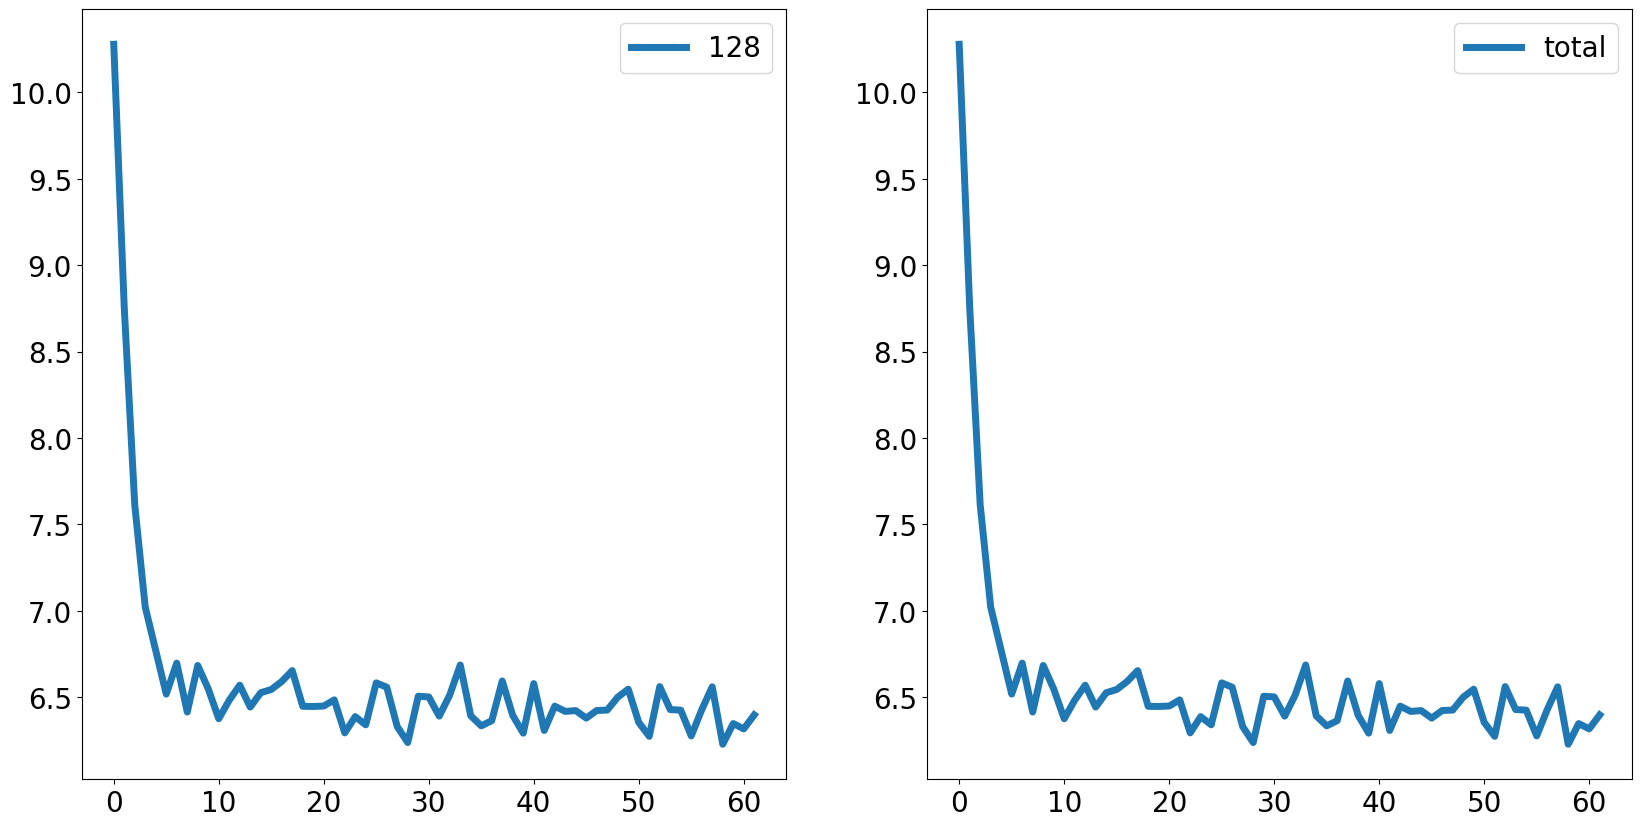

  1%|          | 613/119924 [03:41<12:10:20,  2.72it/s]To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  1%|          | 613/119924 [03:41<11:59:10,  2.77it/s]
Process Process-774:
Process Process-776:
Process Process-779:
Process Process-778:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f790f07b820>
Traceback (most recent call last):
  File "/home/user/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/user/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/user/conda/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/user/conda/lib/python3.9/multiprocessing/popen_fork.py", li

KeyboardInterrupt: 

In [151]:
for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
    X = tokenizer(
        batch['target'],
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
        return_special_tokens_mask=True,
        return_token_type_ids=False,
    ).to("cuda:0")

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        encoder_latents = encoder(token_ids=X["input_ids"])

        losses = []
        
        num_latent = 0
        for n in decoder.latent_resolutions:
            num_latent += n
            
            latents = encoder_latents[:, :n]
            logits = decoder(latents)

            ce_loss = cross_entropy(
                input=logits.view(-1, logits.shape[-1]),
                target=X["input_ids"].view(-1),
            )
                    
            losses.append(ce_loss)

    loss = 0.
    for r, l in zip(decoder.latent_resolutions, losses):
        loss += l * decoder.latent_resolutions[-1] / r

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # logging
    if i % 10 != 0:
        continue
        
    for r, l in zip(decoder.latent_resolutions, losses):
        result[r].append(l.item())
    result["total"].append(loss.item())

    plot_graphs(result)
    